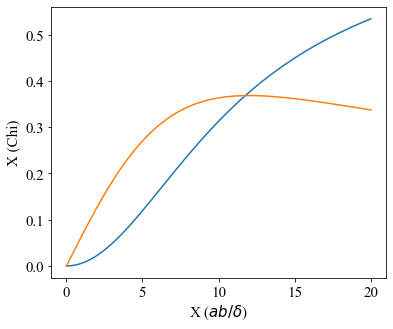

In [2]:
import matplotlib.ticker as ticker
import numpy as np
from numpy import linalg as LA
import cmath
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"
from scipy.interpolate import approximate_taylor_polynomial
from scipy.interpolate import interp1d
import pandas as pd

a = 2*457/430.3 #x dimension in mm
b=2*304/430.3 #y dimension in mm
res = 49 #Minimum resolution in each direction (arbitrary)

d = np.linspace(0.001,20,1000) #d stores values of the parameter X, where 
#X=a*b/delta^2 (delta is the skin depth and sqrt(a*b) is the characteristic 
#length scale). The range of d values can be modified according to what is required,
#but a lower bound of d=0 will produce errors. For reference, the above range of X values
#at 671.111 kHz covers resistivities in the range of 10e5 to 50 uohmcm.

chis = np.zeros(1000,dtype=np.complex_) #Stores the effective magnetic 
#susceptibility for each d value of a rectangular sample (a by b units long)

for u in range(len(d)):
    delta = math.sqrt(a*b/d[u]) #skin depth
    k=(1-1j)/delta #k value
    minn = np.maximum(a,b)
    div = np.maximum(5*int(minn/delta),res) #This analysis is only useful 
    #if there are many more divisions per unit length than the inverse of 
    #the skin depth (Otherwise, valuable information is missed). This is 
    #the reason for increasing the resolution at small skin depths: div 
    #is res by default but becomes larger if the skin depth is sufficiently small.
    
    dx = a/(div+1) #stepsize: x direction
    dy = b/(div+1) #stepsize: y direction
    H0 = 1 #External field magnitude

    """This analysis solves the differential equation del^2(H)+k^2*H=0 over 
    a rectangular sample. A second order approximation for H is used, which 
    is appropriate given the presence of the Laplacian."""

    Xmat = np.zeros([div,div],dtype=np.complex_) #A matrix
    Ymat = np.zeros([div,div],dtype=np.complex_) #B matrix
    for i in range(div):
        for j in range(div):
            if (i ==j):
                Xmat[i][j]= -2/dx**2+k**2/2 #alpha_x
                Ymat[i][j]= -2/dy**2+k**2/2 #alpha_y
            elif (abs(i-j) == 1):
                Xmat[i][j]= 1/dx**2 #beta_x
                Ymat[i][j]= 1/dy**2 #beta_y


    C = np.zeros([div,div],dtype=np.complex_) #boundary conditions (The 
    #component of H parallel to the surface of the conductor is continuous 
    #provided there are no free surface currents.) 
    
    for i in range(div):
        for j in range(div):
            if ((i==0) or (i == (div-1))):
                C[i][j] -= H0/dx**2 
            if ((j==0) or (j == (div-1))):
                C[i][j] -= H0/dy**2
                
    #The steps below were taken from http://aero-comlab.stanford.edu/Papers/jameson_007.pdf 
    #X is the solution to the matrix equation AX + XB = C.

    lam, U = LA.eig(Xmat) #lam stores the eigenvalues, U stores the eigenvectors
    mu, V = LA.eig(Ymat) #mu stores the eigenvales, V stores the eigenvectors

    C_hat = LA.inv(U)@C@V #Equation 16

    X_hat = np.zeros([div,div],dtype=np.complex_)
    for i in range(div):
        for j in range(div):
            X_hat[i][j] = C_hat[i][j]/(lam[i]+mu[j]) #Equation 15

    X = U@X_hat@LA.inv(V) #Equation 14
    for i in range(div):
        for j in range(div):
            if X[i][j].real > 1:
                print("Error at position ",i,", ",j) #It is unphysical for the 
                #field to be larger in magnitude within the conductor than outside of it 
                #(provided that it is not magnetic).
                
    NewX= np.zeros([div+2,div+2],dtype=np.complex_) 
    for i in range(div+2): #This for loop defines the field at the surface 
        #of the conductor (It must be H0).
        
        for j in range(div+2):
            if ((i ==0) or (i==(div+1)) or (j ==0) or (j==(div+1))):
                NewX[i][j] =H0 
            else:
                NewX[i][j]=X[i-1][j-1]
    summ = 0
    for i in range(div+1):
        for j in range(div+1):
            summ += (NewX[i][j]+NewX[i+1][j]+NewX[i][j+1]+NewX[i+1][j+1])*dx*dy/4 #Numerical 
            #integration of H*da
    chis[u]=summ/(H0*a*b)-1 #Solves for the effective magnetic susceptibility
    #at the given X value.
    
fig,bx = plt.subplots(1, 1, sharex = True, figsize=(6, 5))
bx.plot(d,-chis.real)
bx.plot(d,-chis.imag)
bx.set_xlabel("X ($ab/\u03B4$)",fontsize=15)
bx.set_ylabel("\u03A7 (Chi)",fontsize=15)
bx.tick_params(axis='x', labelsize=15)
bx.tick_params(axis='y', labelsize=15)



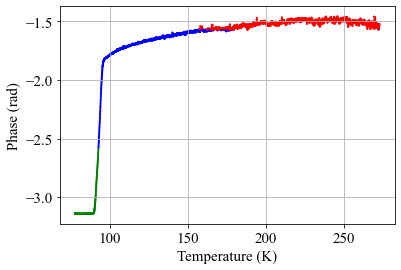

In [57]:
"""Run the top above code cell before running this one."""
import matplotlib.colors as mcolors
f=671111 #Frequency in Hz
phase = np.zeros(len(chis))
for i in range(len(chis)):
    phase[i] = np.angle(chis[i])
    
F=interp1d(phase,d) #Interpolate the data from the plot above such that a phase can
#be mapped to the corresponding X value.

filepath = '/Users/jackzwettler/Documents/2021_3_c.xlsx' #This is the file that contains
#the data from the probe.

probe_dat = pd.read_excel(filepath) #Retrieve data

Xdat = probe_dat.to_numpy() 

low = 3400 #This is the excel row entry when the warming stage begins.
high = 8847 #This is the excel row entry when the warming stage ends.

RT = np.zeros(high-low+1) #Temperature data for this iteration only
RP = np.zeros(high-low+1) #phase data for this iteration only
    
p_off = 0.241 #This phase offset is due to the steel tube, and it is evident in the
#output from a superconducting sample. Specifically, the phase of the output should be 
#zero for a superconductor because chi= -1. However, it is observed that Im(chi) != 0.
        
for i in range(high-2,low-3,-1):
    RT[i-low+2]=Xdat[i][0] #T (K)
    RP[i-low+2]=Xdat[i][6] #Phase (rad). This can be achieved using the "ATAN"
    #function in excel or in python with numpy's "arctan" function.
    
    #Also note that Xdat is 0 indexed, i.e. the first column of an excel file is 
    #stored in Xdat[i][0].
    
    if (RP[i-low+2]> 0):
        RP[i-low+2] -= np.pi+p_off #Unwrap
    else:
        RP[i-low+2] -= p_off
    
Rho = np.zeros(len(RP)) 
skin = np.zeros(len(RP)) 
test = np.zeros(len(RP)) 
color = np.zeros(len(RP))
colors=['red','green','blue']
for i in range(high-2,low-3,-1):
    if (RP[i-low+2]>= max(phase)):
        Rho[i-low+2] = 10e6 #This value is meaningless, something went wrong here
        color[i-low+2]=1 
    elif (RP[i-low+2]<= min(phase)): 
        Rho[i-low+2] = 0 #This value is (possibly) meaningless, but it might just be superconducting   
        color[i-low+2]=2
    else:
        skin[i-low+2] = math.sqrt(a*b/F(RP[i-low+2]))/1000
        test[i-low+2]=F(RP[i-low+2])
        Rho[i-low+2] = (np.pi**2*f*40)*skin[i-low+2]**2
        color[i-low+2]=3
    
fig,bx = plt.subplots(1, 1, sharex = True, figsize=(6, 4))
cmap, norm = mcolors.from_levels_and_colors([0, 1.5, 2.5, 3.5], ['red', 'green', 'blue']) 
bx.scatter(RT,RP,s=1,c=color,cmap=cmap,norm=norm)
bx.tick_params(axis='x', labelsize=15)
bx.tick_params(axis='y', labelsize=15)
bx.set_xlabel('Temperature (K)',fontsize = 15)
bx.set_ylabel('Phase (rad)',fontsize = 15)
bx.grid()


#Red: Data is above the interpolation range (Signal might be too weak or data wasn't 
#processed properly.)
#Blue: Data is within the interpolation range
#Green: Data is below the interpolation range (Superconducting?)



(0.0, 100.0)

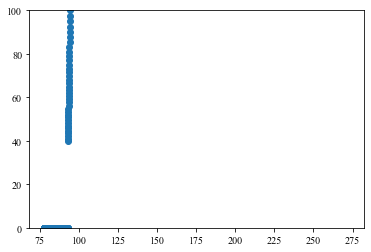

In [46]:
plt.plot(RT,Rho,'o')
plt.ylim([0,100])

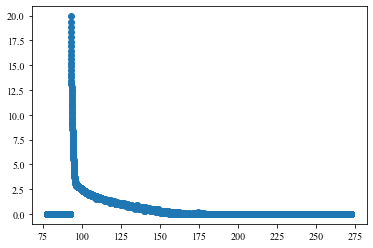

In [36]:
plt.plot(RT,test,'o')

In [53]:
norm